# Convolutional encoding

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import qsvm4eo
from qsvm4eo.utils import plot_label_grid_with_points
import numpy as np
import pandas as pd 


In [3]:
df_train = pd.read_csv("./../data/train_32.csv")
df_test = pd.read_csv("./../data/test_32.csv")
encoding_train = qsvm4eo.ConvolutionalEncoding(
    df_train
)
encoding_test = qsvm4eo.ConvolutionalEncoding(
    df_test
)

This encoding uses the geospatial attributes of our data to generate the graphs. As our datasets will have values of latitude and longitude, we can use them to place our datapoints in a grid, as we can see in the plot below.

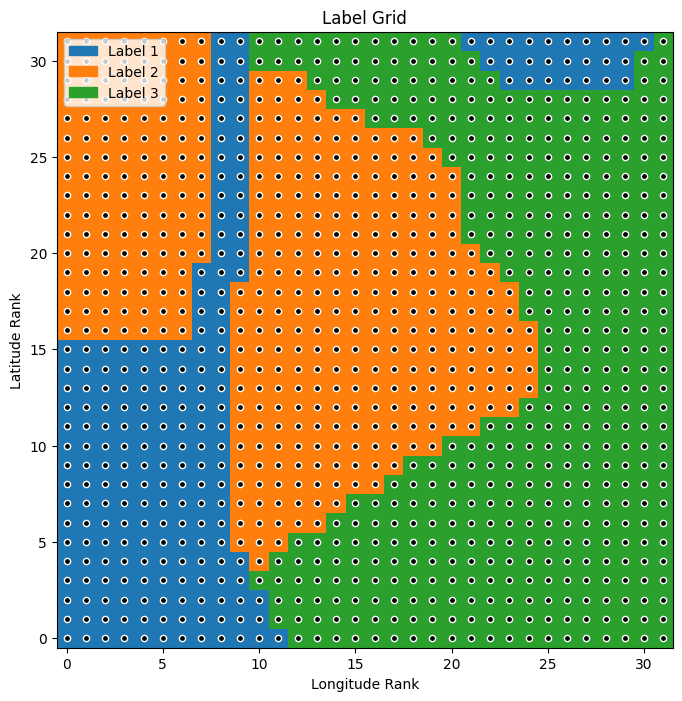

In [4]:
qsvm4eo.utils.plot_label_grid_with_points(df_train)

The main idea behind this encoding is to convolute the different points of our dataset to form graphs of N points. We can use these graphs as input to run the SVM in our analog quantum computer. 

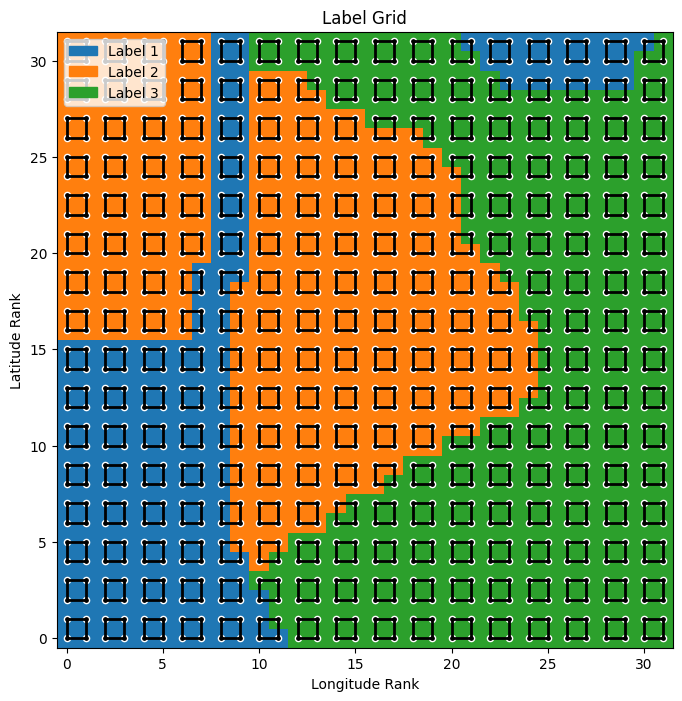

In [5]:
qsvm4eo.utils.plot_label_grid_with_points(df_train, draw_squares=True)

Now, our input data will be graphs with $N=4$ points. As we can see in the plot above, in some cases the nodes within a graph have different labels. To assign a single label to each of the graphs, we will use a majority vote among all the nodes in the graph.

Once we have the graphs defined, we need to assign coordinates $(x,y)$ to each of the nodes. It is important here that we don't mistake the encoding coordinates assigned to each of the nodes with the spatial coordinates of our original datapoints. 

Each of the nodes have values of colours given by the spectral bands. Concretely, bands 2,3 and 4 are assigned to colours Blue, Green and Red respectively in the [RGB colour model](https://en.wikipedia.org/wiki/RGB_color_model). 

From these RGB coordinates we can compute the [HUE angle](https://en.wikipedia.org/wiki/Hue), whose formula is given by: 

$\\[25pt]$

$
H =
\begin{cases} 
\text{undefined}, & \text{if } C = 0 \\[15pt]
\dfrac{G - B}{C} \bmod 6, & \text{if } M = R \\[15pt]
\dfrac{B - R}{C} + 2, & \text{if } M = G \\[15pt]
\dfrac{R - G}{C} + 4, & \text{if } M = B
\end{cases}
$

$\\[15pt]$ 

$\mathcal{H} = 60^\circ \times H$


$\\[25pt]$

where, 


- $M = max(R,G,B)$
- $m = min(R,G,B)$
- $C = range(R,G,B) = M - m$

This way we have an angle $\mathcal{H}_i$ assigned to each node of each of the graphs. Let's consider now a graph of $N$ nodes $G$. We will assign the coordinates to its nodes $(x_i, y_i)$ with $i=1,...,N$ the following way. 

We first define the following quantity: 

$$ 
\Delta\  = \frac{\pi}{N^{2}} 
$$ 

Then the angle $\mathcal{H}_i$ associated to each node of the graph will be given by the formula: 

$$
\mathcal{H}_i^{'} = (\mathcal{H}_i \mod \Delta) + 2i\Delta
$$

And the coordinates for each of the nodes of the graph will be: 

$$
x_i = Rcos\mathcal{H}_i^{'}\\
y_i = Rsin\mathcal{H}_i^{'}
$$,

where R or scaling factor is an integer.







The division of the $\mathcal{H}_i^{'}$ and the value of $R$ are chosen so that our graphs are embeddable in the device. The embeddability of the graphs into the device will depend on factors like the minimal distance between the nodes of the graph, or their distance to the centre. 

In [6]:
qbits_train, y_train = encoding_train.hsv_encoding(scaling=37)
qbits_test, y_test = encoding_test.hsv_encoding(scaling=37)

We can see in the plot below how with this encoding, the nodes of the graphs are placed in a circle of radius R. 

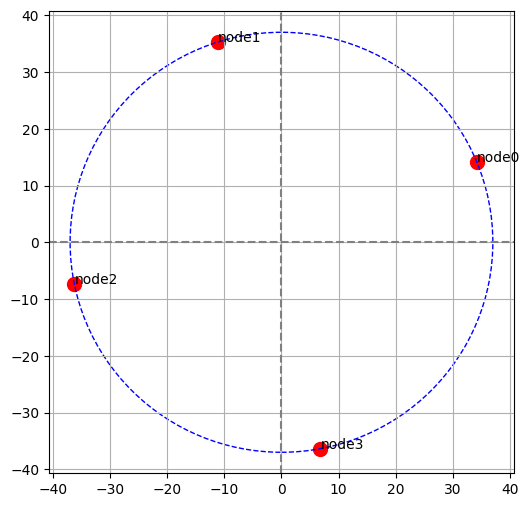

In [7]:
x = qbits_train[0]
radius = 37 
plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], color="red", s=100)
for i, (x, y) in enumerate(x):
    plt.text(x + 0.05, y + 0.05, f"node{i}")

# Plot the unit circle for reference
circle = plt.Circle(
    (0, 0), radius, color="blue", fill=False, linestyle="--", linewidth=1
)
plt.gca().add_patch(circle)

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.grid(True)
plt.show()
plt.close()


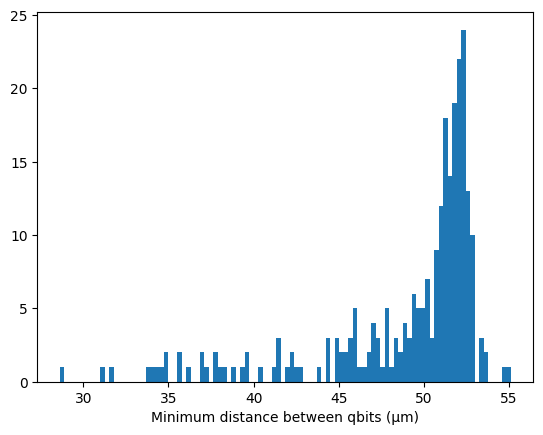

In [8]:

# Finally let's see what the minimum distance between the qubits looks like.
def get_qbit_distances(qbit_coords):
    d_ij = []
    for i in range(0, 3):
        for j in range(i + 1, 3):
            d_ij.append(np.linalg.norm(qbit_coords[i] - qbit_coords[j]))
    return np.array(d_ij)


dists_train = np.array([get_qbit_distances(q) for q in qbits_train])

plt.hist(np.min(dists_train, 1), bins=100)
plt.xlabel("Minimum distance between qbits (µm)")
plt.show()